# Project
Space Titanic from Kaggle

## Dataset
The dataset used consists of the following columns

| \# | Filename | Description |
| --- | --- | --- |
| 1 | train.csv| Dataset used for the training of the model |
| 2 | test.csv| Dataset used for testing the model |

The difference between `train.csv` and `test.csv` data is that test data has different values and one less column, which in this case it is `Transported` column, that is the "Target" of our model i.e. the column that is being predicted.

In [43]:
# Importing necessary python libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Imporint data processing and machine learning libraries :
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Avoiding the warning messages shown in jupyter notebook for better visibility:
warnings.filterwarnings("ignore")


# Formating the background of the diagrams and visuals in jupyter notebook:
plt.style.use('ggplot')
sns.set_style('whitegrid')

In [3]:
# Checking the datasets files exist or not, and their names:
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        if not filename.endswith('ipynb'):
            print(os.path.join(dirname, filename))

./titanic/test.csv
./titanic/train.csv


In [4]:
# importing the datasets we have:
train_file = './train.csv'
test_file = './test.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [5]:
# Checking null values in the training data:
print(f'Nulls in training dataset:\n--------\n{train_data.isnull().sum()}\n\n')
print(f'Nulls in testing dataset:\n--------\n{test_data.isnull().sum()}')

Nulls in training dataset:
--------
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


Nulls in testing dataset:
--------
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [6]:
# Overview of the training dataset first 5 rows:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
# Overview of the testing dataset first 5 rows:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [8]:
# Droping nulls from the training dataset and checking the number of nulls dropped
train_shape = train_data.shape[0]
train_data.dropna(inplace=True, axis=0)
print('Number of NaN rows removed is: ', train_shape - train_data.shape[0])

Number of NaN rows removed is:  2087


In [9]:
# Droping nulls from the testing dataset and checking the number of nulls dropped
test_shape = test_data.shape[0]
test_data.dropna(inplace=True, axis=0)
print('Number of NaN rows removed is: ', test_shape - test_data.shape[0])

Number of NaN rows removed is:  996


In [10]:
# getting the list of columns with "boolean" and "object" type:
cols_obj_bool = list(train_data.select_dtypes(include=[object, bool]))
cols_obj_bool

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name',
 'Transported']

#### Splitting `cabin` column into three columns, to convert its type to `binary` e.g. 0 or 1

In [11]:
train_data[['Deck', 'DeckNum', 'Side']] = train_data['Cabin'].str.split('/', expand=True)
test_data[['Deck', 'DeckNum', 'Side']] = test_data['Cabin'].str.split('/', expand=True)

#### Checking the other columns to see their unique values, and based on these values they are splitted into different columns, if their unique values are less than 10 each, to avoid multiple columns from being created:

In [12]:
cols = ['HomePlanet', 'Deck', 'Side', 'Destination']

for col in cols:
    col_name = np.unique(train_data[col]).tolist()
    print(f'Column "HomePlanet" has the following unique values: {col_name}')

Column "HomePlanet" has the following unique values: ['Earth', 'Europa', 'Mars']
Column "HomePlanet" has the following unique values: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
Column "HomePlanet" has the following unique values: ['P', 'S']
Column "HomePlanet" has the following unique values: ['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e']


In [13]:
cols = ['HomePlanet', 'Deck', 'Side', 'Destination']

for col in cols:
    col_name = np.unique(test_data[col]).tolist()
    print(f'Column "HomePlanet" has the following unique values: {col_name}')

Column "HomePlanet" has the following unique values: ['Earth', 'Europa', 'Mars']
Column "HomePlanet" has the following unique values: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
Column "HomePlanet" has the following unique values: ['P', 'S']
Column "HomePlanet" has the following unique values: ['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e']


In [14]:
bool_cols = ['CryoSleep','VIP','Transported']
for col in bool_cols:
    train_data[col] = pd.Series(np.where(train_data[col].values == True, 1, 0), train_data.index)

In [15]:
bool_cols = ['CryoSleep','VIP']
for col in bool_cols:
    test_data[col] = pd.Series(np.where(test_data[col].values == True, 1, 0), test_data.index)

In [16]:
train_data['BilledAmeni'] = train_data['RoomService'] + train_data['FoodCourt'] +\
train_data['ShoppingMall'] + train_data['Spa'] + train_data['VRDeck']
train_data.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin', 'Name'],
       inplace=True, axis=1)
train_data['Side'] = pd.Series(np.where(train_data['Side'].values == 'S', 1, 0), train_data.index)


In [17]:
test_data['BilledAmeni'] = test_data['RoomService'] + test_data['FoodCourt'] +\
test_data['ShoppingMall'] + test_data['Spa'] + test_data['VRDeck']
test_data.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin', 'Name'],
       inplace=True, axis=1)
test_data['Side'] = pd.Series(np.where(test_data['Side'].values == 'S', 1, 0), test_data.index)


#### Other columns such as below are mapped so their `categorical` values could have `numeric` values:

In [18]:
mapping = {'Earth': 1, 'Mars': 2, 'Europa': 3}
train_data.replace({'HomePlanet': mapping}, inplace=True)

In [19]:
mapping = {'Earth': 1, 'Mars': 2, 'Europa': 3}
test_data.replace({'HomePlanet': mapping}, inplace=True)

In [20]:
mapping = {'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5, 'F' : 6, 'G' : 7, 'T' : 8}
train_data.replace({'Deck': mapping}, inplace=True)

In [21]:
mapping = {'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5, 'F' : 6, 'G' : 7, 'T' : 8}
test_data.replace({'Deck': mapping}, inplace=True)

In [22]:
mapping = {'55 Cancri e': 1, 'PSO J318.5-22': 2, 'TRAPPIST-1e': 3}
train_data.replace({'Destination': mapping}, inplace=True)

In [23]:
mapping = {'55 Cancri e': 1, 'PSO J318.5-22': 2, 'TRAPPIST-1e': 3}
test_data.replace({'Destination': mapping}, inplace=True)

In [24]:
cols = train_data.columns.tolist()
print('Features:\n', cols, end='\n\n')
tr = train_data.columns.get_loc('Transported')
cols_sorted = cols[:tr] + cols[tr+1:] + [cols[tr]]
print('Sorted Features:\n', cols_sorted, end='\n\n')
train_data = train_data[cols_sorted]
train_data.head()

Features:
 ['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'Transported', 'Deck', 'DeckNum', 'Side', 'BilledAmeni']

Sorted Features:
 ['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'Deck', 'DeckNum', 'Side', 'BilledAmeni', 'Transported']



,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Deck,DeckNum,Side,BilledAmeni,Transported
0,0001_01,3,0,3,39.0,0,2,0,0,0.0,0
1,0002_01,1,0,3,24.0,0,6,0,1,736.0,1
2,0003_01,3,0,3,58.0,1,1,0,1,10383.0,0
3,0003_02,3,0,3,33.0,0,1,0,1,5176.0,0
4,0004_01,1,0,3,16.0,0,6,1,1,1091.0,1


Now the correlation between all the columns could be measured to see if any of the columns can impact other columns in a negative or positive way. Correlation coefficients are used to measure the strength of the linear relationship between two variables. These columns would be helpful to choose to train the model.
- Correlation values:
    - zero: no correlation i.e. no relationship
    - near zero: weak relationship
    - Above zero: positive relationship, e.g. when one column's value increases, the other column also increases.
    - Below zero: negative relationship, e.g. when one column's value increases, the other column also decreases. 

<Axes: >

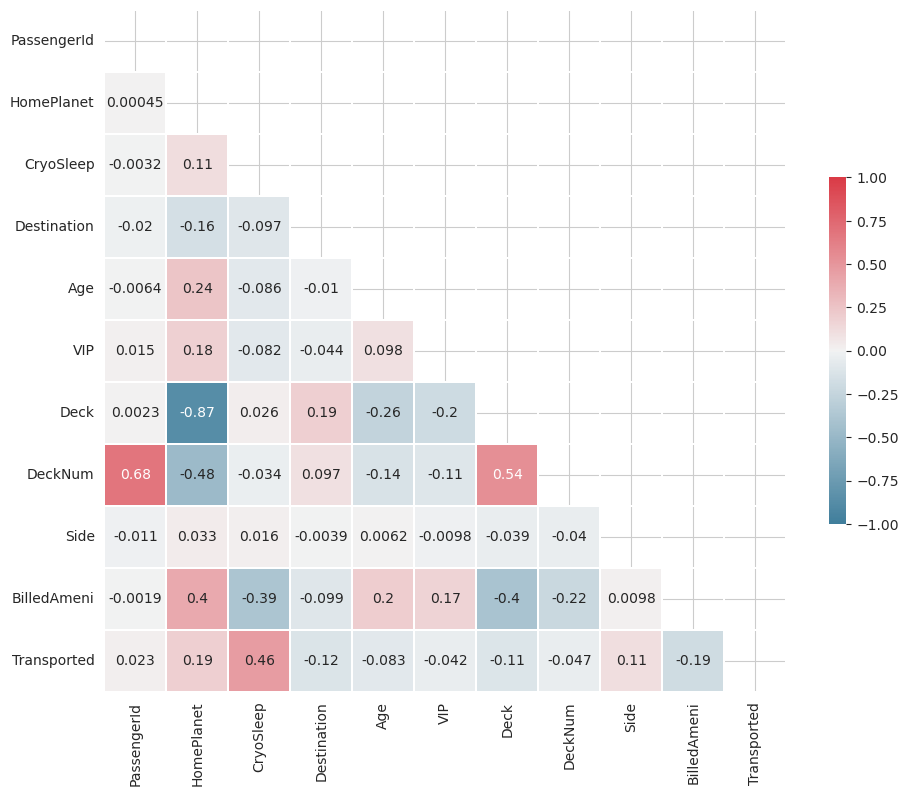

In [25]:
corr = train_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, annot_kws={"size": 10},
            vmin=-1, vmax=1, center=0, square=True, linewidths=0.1,
            cbar_kws={"shrink": .5})

#### We can see that `Deck` and `HomePlanet` columns are correlated, which means if you come from a certain planet you must likely to be in a certain deck that the majority of its residents come from your planet.

Here we are using `X` which contains all columns except `Transported` column, and `y` contains only `Transported` column

In [26]:
X = train_data.iloc[:,:-1]
y = train_data.iloc[:,-1]

Using *Principal component analysis* (PCA), to remove all related columns that could cause overfitting. In other words, it removes any noise.

*Overfitting* is when the model cannot generalise, which is caused by different reasons including related/highly correlated columns.

In [37]:
pca = PCA(n_components=0.95)
scale = StandardScaler()
scale.fit(X)
X = scale.fit_transform(X)

pca.fit(X)
X = pca.transform(X)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25)

model = RandomForestClassifier(random_state=1)
model.fit(train_X, train_y)
pred = model.predict(val_X)
rmse = mean_squared_error(pred, val_y, squared=False)

print(f'Model Error is: {round(rmse, 2)*100} %')

Model Error is: 51.0 %


When the model's error (RMSE) value ≥ 50%, it means the model is performing poorly.

In [51]:
r2 = r2_score(val_y, pred)

n_x = len(val_X)
r2_per = 1-(1-r2)*((n_x-1)/(n_x-len(val_X[0])-1))

Adj_r2 = 1 - (1-r2) * (len(y)-1)/(len(y)-X.shape[1]-1)

print(f'R2 is:\n{round(r2, 4)}\n')
print(f'R2 percentage is:\n{round(r2_per, 4)}\n')
print(f'Adjusted R2 is:\n{round(Adj_r2, 4)}\n')

R2 is:
-0.0509

R2 percentage is:
-0.056

Adjusted R2 is:
-0.0521



"Adjusted R2 identifies the percentage of variance in the target field that is explained by the input or inputs. A value of 1 indicates a model that perfectly predicts values in the target field. **A value that is less than or equal to 0 indicates a model that has no predictive value.**"

source: https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=terms-adjusted-r-squared

So based on the values above, this model has no predictive value, which means **it needs more adjustments** to fix this issue.

In [30]:
scale.fit(test_data)
test_X=scale.fit_transform(test_data)
pca.fit(test_X)
test_X = pca.transform(test_X)

test_pred = model.predict(test_X)

predict_df = pd.DataFrame({'PassengerId': test_data.PassengerId,
                           'Transported': test_pred})

mapping = {1: 'True', 0: 'False'}
predict_df.replace({'Transported': mapping}, inplace=True)

predict_df.to_csv('./titanic/submission.csv', index=False)

Exporting the data to a separate `submission.csv` file

In [31]:
predict_df

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
4269,9263_01,True
4270,9265_01,False
4271,9266_01,True
4272,9266_02,True
